In [1]:
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Pre-class Work - Option Trading

In this session, we will learn that theoretical option pricing is key to options trading. The Black-Scholes model is the most important option pricing model, and its extensions can be used in various option trading scenarios. It is very hard to find a reading of the BS model that strikes a good balance between theoretical rigor and practical usability. Therefore, in this pre-class notebook, I will try to explain and demonstrate the model with Monte Carlo simulations. Please first read the readings (which may seem a bit hard to understand), then proceed with this notebook.

### Assumptions

The vanilla BS model that we will focus on in this session has some key assumptions:

1. The option is European and can only be exercised at expiration.
    - American options can be excercised anytime before expiration, thus making it more complex than the European ones. However, you can make some modifications to the BS model and it will be completely compatible with American options. We won't go into detail this session, but you can find a decent amount of literature that uses different variations of the BS model to trade American, Asian, or other "exotic" options.
2. No dividends are paid out during the life of the option.
3. Markets are efficient (i.e., market movements cannot be predicted).
    - The efficient market hypothesis states that financial markets are “efficient” in that prices already reflect all known information concerning a stock. Information includes not only what is currently known, but also future expectations, such as earnings and dividends. Only new information will move stock prices significantly, and since new information is presently unknown and occurs at random, good or bad, future movements in stock prices are also unknown and thus, random. The basis of the efficient market hypothesis is that the market consists of many rational investors who are constantly reading the news and reacting quickly to any new significant information about a security.
4. There are no transaction costs in buying the option.
    - Brokers do charge commissions for your options trades. This can also be modeled by just adding the transaction cost to your pricing model. Taxes are also a consideration for transaction costs.
5. The risk-free rate and volatility of the underlying are known and constant.
    - The risk-free rate (e.g. interest rate) is subject to changes. Same does the volatility, because volatility fluctuates with the level of supply and demand.
6. The returns on the underlying asset are normally distributed.
    - One of the most important assumptions! I will explain this assumption below.


**Geometric Brownian Motion**

Before we go into the details of the BS model, we need to address the assumption 6 above. Understanding this assumption can help us master the model. In chapter 6 of Natenberg's book, you already know how the price and the volatility correspond to the mean and standard deviation of an asset price. In the mathematical language, we often say that the price of a stock follows Geometric Brownian Motion (GBM).

Suppose a stock price $S$ is going to fluctuate randomly. The fluctuation $dS$ for any small time interval $dt$ follows $N(0,\sigma^2dt)$. This is equivalent to $\sigma\sqrt{dt}Z_t$, where $Z_t\sim{N(0,1)}$. 

But sometimes the price of a stock does seem to have a trend (i.e. doesn't have a mean of 0). We can add another term called drift, $\mu$, to model any long term inclination of a stock price. That gives us $dS = \mu dt+\sigma\sqrt{dt}Z_t, Z_t\sim{N(0,1)}$.

That sounds cool, right? Not really. The movement of a stock price is NOT unlimited - it can't go below 0. If we stick with the current equation for $dS$, there is a chance that the price can drop infinitely. To solve this problem, an MIT professor came up with this idea: a stock’s price increment should be proportional to the present price, i.e. $dS = S_t(\mu dt+\sigma\sqrt{dt}Z_t), Z_t\sim{N(0,1)}$. When a stock's price is 0, the jump of the price should also be 0. 

This gives of the final equation for GBM: $$\frac{dS}{S_t} = \mu dt+\sigma\sqrt{dt}Z_t, Z_t\sim{N(0,1)}$$


In [6]:
sts.norm.rvs(0,1)

-0.02018954926826128

Now you may understand the GBM model. Let's do some simulations to see how this model approximates stock price! Here we take the random walk approach we learned in CS166. For each time step, we generate a $dS$ based on the GBM formula through random sampling from a normal distribution. Please fill in the code below:

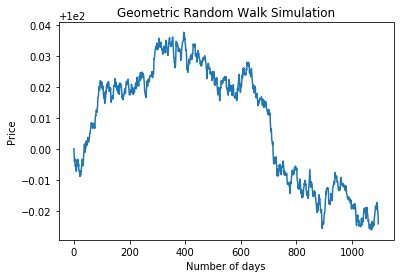

In [10]:
# Simulate GBM.

class GBM():

    def __init__(self,start_price = None, time = None, drift = 0, volatility = 1):
        '''
        time: time in years
        drift: mu, per year, calculated on calendar year (365 days instead of 252 days)
        volatility: standard deviation sigma, per square root year, calculated on calendar year (365 days instead of 252 days)
        '''
        self.time = time
        self.drift = drift
        self.volatility = volatility
        self.dt = 1/365 # Assume that each time step is for one day
        self.price = [start_price]

    def simulation(self):
        for i in range(round(self.time*365)-1):
            S_t = self.price[-1]
            ### Fill in the code below
            Z_t = sts.norm.rvs(0,1)
            dS =  self.volatility*Z_t*self.dt
            self.price.append(S_t + dS)
    
    def display(self):
        plt.plot(range(round(self.time*365)),self.price)
        plt.title('Geometric Random Walk Simulation')
        plt.xlabel('Number of days')
        plt.ylabel('Price')
        plt.show()


a = GBM(start_price = 100, time = 3, drift = 0, volatility = 0.4) # Assume the drift is zero.
a.simulation()
a.display()

Doesn't it look at a stock price movement? Now that we've simulated the movement of a stock price. You can buy the stock at any moment in time, and sell it at another. You may wonder: how would the ending price of the stock look like? When you purchase a stock, and sell it in 3 years' time, how would the stock price, at the end of the period, be distributed? What's the probability of making/losing money? We can also show this through the GBM model.



#### *Theoretical Analysis*

Here I will do a quick theoretical derivation of the distribution we are going to show, if you don't feel like it, just skim through below and jump to the conclusion.

The end price of a stock price $S$ after a time period $T$, $S_T$ can be found by:

First,
$$S_{i+1} = S_i(1 + \mu\Delta{t} + \sigma\sqrt{\Delta{t}}Z_i)$$

Therefore, 
$$S_T = S_0\prod_{i=1}^{n}(1 + \mu\Delta{t} + \sigma\sqrt{\Delta{t}}Z_i)$$

The exact $S_T$ is the limit of the above as $n\rightarrow{\infty}$ (or as $\Delta{t}\rightarrow{0}$)

Using Taylor Series to solve the above limit, we can find out that **$S_T$ follows a lognormal distribution, i.e. $\log{S_T}$ follows a normal distribution** with parameters $$\mathop{\mathbb{E}}[\log{S_T}]=\log{S_0}+\mu T - 1/2\sigma^2T$$ and $$\text{var}{[\log{S_T}]}=\sigma^2T$$

So similarly, $\frac{S_T}{S_0}$ follows a lognormal distribution: 
$$\frac{S_T}{S_0} \sim LogN(\mu T - 1/2\sigma^2T,\sigma^2T)$$

**P.S. $\frac{S_T}{S_0}$ is just the return (end price versus start price) you have when you trade the stock, which follows a lognormal distribution.**

Okay, now let's plot the distribution and observe.

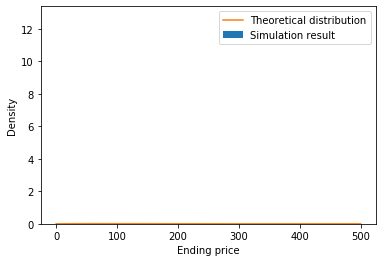

In [12]:
# Simulate for an ending price S_T, this may take a while.

result = []
# Simulate for 1000 times and record the ending price
for i in range(1000):
    sim = GBM(start_price = 100, time = 3, drift = 0, volatility = 0.4)
    sim.simulation()
    result.append(sim.price[-1])


# Plot the result
plt.hist(result,bins=50,density=True,label='Simulation result')
x = np.linspace(0,500,500)
# Plot the theoretical lognormal distribution.
plt.plot(x,sts.lognorm.pdf(x,s = 0.4*3**0.5, scale = np.exp(np.log(100)-3*0.5*0.4**2)),
         label='Theoretical distribution')
plt.xlabel('Ending price')
plt.ylabel('Density')
plt.legend()
plt.show()

### Black-Scholes Model

Okay, now we've establish the basis of the BS Model. We can then derive the formula from the conclusions that we drawn above.

We know that the ending price of a stock, $S_T$, follows a lognormal distribution. If we set the drift $\mu$ as the risk-free interest rate $r$, we can get the risk-free growth of the asset. We can write out the density of this lognormal distribution: $$g(S)=\frac{1}{S\beta\sqrt{2{\pi}}} e^{-\frac{(\log{S}-\alpha)^2}{2\beta^2}}$$

where $\alpha=\log{S_0}+(r-\frac{\sigma^2}{2})T$ is the mean and $\beta=\sigma\sqrt{T}$ is the standard deviation of the distribution.

Then, to calculate the expected payoff from this lognormal distribution, all we need to do is to integrate this density against the payoff function $G(S)$.

$$\mathop{\mathbb{E}}(\text{Payoff})=\int_{0}^{\infty}G(S)g(S)dS$$

In a call option, $G(S)=\max(S-K,0)$ and in a put option, $G(S)=\max(K-S,0)$, where $K$ is the strike price.

Solving this integral is not trivial, thus we will not cover it in this session. The result of the integral is the Black-Scholes formula:

$$C=S_0\phi({d_1})-Ke^{-rT}\phi(d_2)$$
$$P=Ke^{-rT}\phi(-d_2)-S_0\phi({-d_1})$$

and $$d_1=\frac{\log(S_0/K)+(r+\frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}$$ $$d_2=d_1-\sigma\sqrt{T}=\frac{\log(S_0/K)+(r-\frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}$$

where $$C = \text{Call price}$$ $$P = \text{Put price}$$ $$S_0 = \text{Current underlying price}$$ $$K = \text{Strike price}$$ $$T = \text{Time to expiration}$$ $$r = \text{Risk-free interest rate}$$ $$\phi = \text{The cumulative distribution of a normal distribution}$$

Now that we have the BS formula. We can use it to price an option.

**Exact Solution**

First of all, let's code the BS model. (In all of the below excersies, we will assume it's a call option)

In [24]:
def BS_call(S,T,r,K,sigma):
    ### Fill in the code below to calculate a call option price
    d_1 = (np.log(S/K) + (r + sigma**2)*T)/(sigma*np.sqrt(T))
    d_2 = d_1 - sigma*np.sqrt(T)
    C = S*sts.norm.cdf(d_1)-K*np.exp(-r*T)*sts.norm.cdf(-d_2)
    return C

We can then observe how the option price changes with respect to the time from expiration $T$.

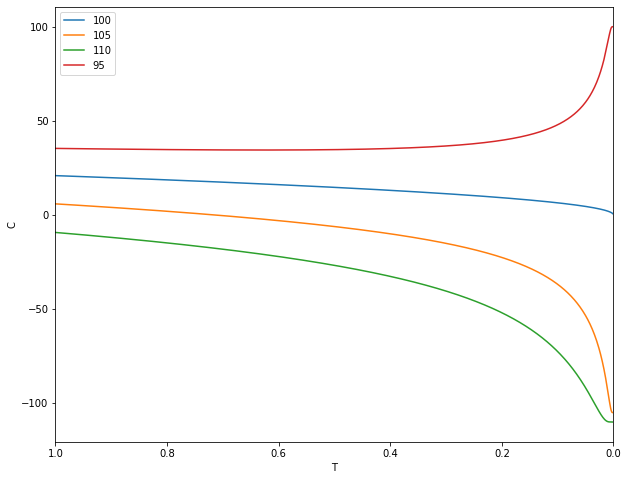

In [26]:
T = np.arange(1.0, 0.0, -0.001)
S = 100
r = 0.03
sigma = 0.3
# Please try 4 different K values below. Experiment around when strike price is above/equal/below the current price.


### Fill in the code below
plt.figure(figsize=(10,8))
sns.lineplot(T,BS_call(S,T,r,100,sigma), label="100" )
sns.lineplot(T,BS_call(S,T,r,105,sigma), label="105" )
sns.lineplot(T,BS_call(S,T,r,110,sigma), label="110" )
sns.lineplot(T,BS_call(S,T,r,95,sigma ), label="95" )

plt.xlabel('T')
plt.ylabel('C')
plt.xlim(1.0,0.0)

plt.legend()
plt.show()

We can also replicate the profit & loss diagram here. In particular, you can set $T=0$, and make a plot with $C$ on the y-axis and $S$ on the x-axis.



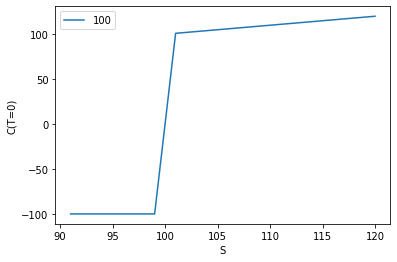

In [37]:
### Fill in the code below, assume strike price is 100
S = np.arange(120, 90, -1)
T = 0
r = 0.03
sigma = 0.3
K = 100

plt.figure()
sns.lineplot(S,BS_call(S,T,r,K,sigma), label="100" )

plt.xlabel('S')
plt.ylabel('C(T=0)')

plt.legend()
plt.show()

**Monte Carlo Simulation**

Remember the Monte Carlo simulation that we did in the beginning? Turns out it can also be used for option pricing, and can obtain the same result as the BS model. 

Remember that we simulated the stock price after some period of time with the GBM model? Recall that $S_T$ follows a lognormal distribution with parameters

$$\mathop{\mathbb{E}}[\log{S_T}]=\log{S_0}+\mu T - 1/2\sigma^2T$$ and $$\text{var}{[\log{S_T}]}=\sigma^2T$$

We substituted the drift $\mu$ with the risk-free rate $r$. Therefore $\mathop{\mathbb{E}}[\log{S_T}]=\log{S_0}+rT - 1/2\sigma^2T$.

Now, suppose that we want to purchase a call option on this stock with strike price $K$. The expiration time is just the ending time $T$. We also know that the value of the call option at expiration is $\max(S_T-K,0)$. We can now generate stock ending price from the above lognormal distribution, and then calculate the corresponding call option value at expiration. Note that what we obtain from this is the value of option at the date of expiration, so to calculate the current option value, we need to discount it to the present value by multiplying it with $e^{-rT}$

Take a step backward, generating a stock ending price from the lognormal distribution is exactly what we did with the GBM model simulation in the first section! Therefore, all we need is to bring back the GBM and calculate the option price from it.


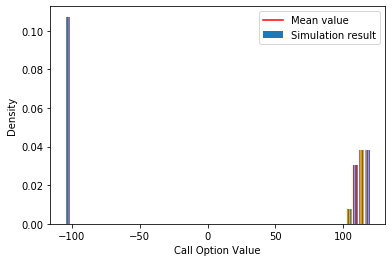

In [39]:
##### Monte Carlo simulation for option price.

S_0 = 100 # Current price
r = 0.03 # Risk-free rate
T = 1.0 # 1 year to expiration
sigma = 0.3 # Volatility

# Please experiment with different strike values
K = 105

results = []

for i in range(3000):
    ### Fill in the code below
    option_mc = GBM(start_price = 100, time = 1, drift = 0.03, volatility = 0.4) # Note here the drift is the risk-free interest rate
    option_mc.simulation()
    S_T = 100
    C_T = BS_call(S,T,r,K,sigma)
    C_0 = BS_call(S,0,r,K,sigma)
    results.append(C_0)

# Calculate the average of the results.
results_mean = np.mean(results)

# Plot the result
plt.hist(results,bins=50,density=True,label='Simulation result')
# Plot the mean
plt.axvline(results_mean,color='r',label='Mean value')
plt.xlabel('Call Option Value')
plt.ylabel('Density')
plt.legend()
plt.show()

Now, let's compare the results of Monte Carlo with the BS model.

In [40]:
BS_value = BS_call(S_0, T, r, K, sigma)
print('Call option value from Monte Carlo:',results_mean)
print('Call option value from Black-Scholes:', BS_value)

Call option value from Monte Carlo: nan
Call option value from Black-Scholes: 5.888508921889766


*Optional*: In the above we tried generate samples using GBM and calculate the option price. Instead of using GBM, you can try to generate ending price samples directly from the theoretical lognormal distribution and then compute the option value. The result should be closer to the BS model because it eliminates the uncertainties associated with generating from GBM.